# Chapter 04 - Training Models 

## Linear Regression

In [1]:
import numpy as np

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

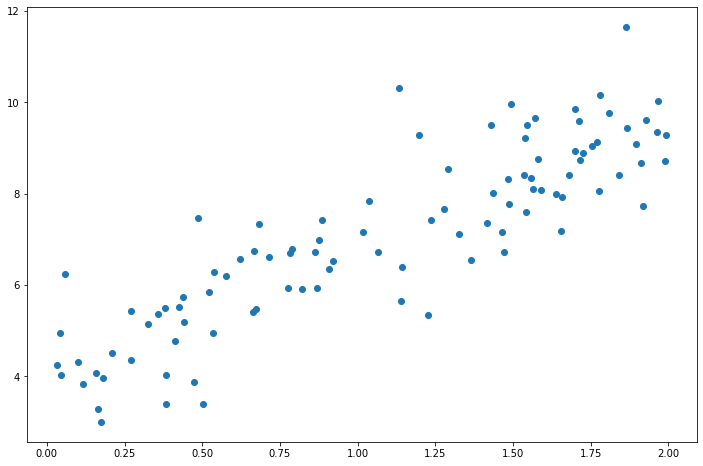

In [3]:
plt.figure(figsize = (12, 8))
plt.scatter(X, y)
plt.show()

Se ve el randomness... pero también se ve el efecto de la función lineal (más o menos y = 3X + 4)

In [4]:
# Cálculo de parámetros a mano
X_b = np.c_[np.ones((100, 1)), X] # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

theta_best

array([[4.04254954],
       [2.80134064]])

Bastante bien... Casi 3 y casi 4

In [5]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new] # add x0 = 1 to each instance
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.04254954],
       [9.64523082]])

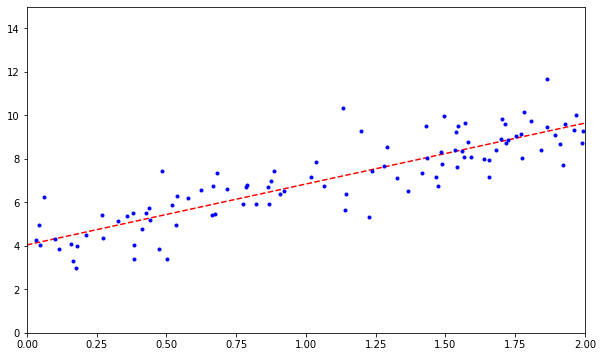

In [6]:
plt.figure(figsize = (10, 6))

plt.plot(X_new, y_predict, "r--")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

Más o menos se ajusta bien

## Gradient Descent
La idea es tocar los parámetros de la función para minimizar la función costo

In [7]:
# gradient descent a manopla
eta = 0.1 # learning rate (greek letter eta)
n_iterations = 1000
m = 100
theta = np.random.randn(2,1)  # random seed

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients  # Esta es la parte iterativa! Calcula theta nuevo a partir del paso anterior!

In [8]:
theta

array([[4.04254954],
       [2.80134064]])

#### Si cambio eta, cambian los ajustes.

### Stochastic Gradient Descent with learning schedule.

In [9]:
m = 100  # ???
n_epochs = 50  # Epochs to train
t0, t1 = 5, 50  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)


theta = np.random.randn(2,1)  # random seed
for epoch in range(n_epochs):  # Una iteración
    for i in range(m):  # No entiendo bien qué es m ...
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        

In [10]:
theta

array([[4.09300315],
       [2.76716984]])

OK... SGD da parecido a BGD

SGD Linear Regression in sklearn

In [11]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None)

In [12]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.01853929]), array([2.85609835]))

OK. vemos que esta solución iterativa también converge a algo más o menos lógico